## Deep MLP for Jet-Images using jet constituents in HLS data
## Author: Andre Sznajder

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
#data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_30p_val/'

# Load train and test JetID datasets as numpy arrays 

In [1]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]

# Flatten the 2D ( eta x phi ) jet image into 1D array to input into a MLP 
X_train_val = rearrange(  X_train_val , 'batch nconstit nfeat -> batch (nconstit nfeat)' )  
X_test = rearrange(  X_test , 'batch nconstit nfeat -> batch (nconstit nfeat)' )  

print("Flattened X_train_val ----> shape:", X_train_val.shape)
print("Flattened X_test ----> shape:", X_test.shape)


Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)
Flattened X_train_val ----> shape: (589600, 96)
Flattened X_test ----> shape: (290400, 96)


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



## Define our Deep MLP model


In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils
#from tensorflow.keras import mixed_precision

print("X type=",type(X_train_val))
print("X shape=",X_train_val.shape)

# Define MLP input layer dimension ( NINPUT = neta*nphi )
NINPUT = len(X_train_val[1])
NOUTPUT = len(Y_train_val[1])


print("NINPUT = ",NINPUT)
print("NOUTPUT = ",NOUTPUT)

'''
# MLP architechture for 32 contituents
nhidden1 = int(NINPUT/3.3)
nhidden2 = int(NINPUT/3.3)
nhidden3 = int(NINPUT/3.3)
'''

'''
# MLP architechture for 16 contituents
nhidden1 = int(NINPUT*0.8)
nhidden2 = int(NINPUT*0.8)
nhidden3 = int(NINPUT*0.8)
'''

#'''
# MLP architechture for 8 contituents
nhidden1 = int(NINPUT*1.75) 
nhidden2 = int(NINPUT*1.75) 
nhidden3 = int(NINPUT*1.75) 
#'''

#############################################################################################


# Define the input tensor shape
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = BatchNormalization(name='batchnorm')(input)

# Define MLP with 2 hidden layers 
hidden = Dense(nhidden1,  name = 'Dense1', activation='relu')(hidden)
hidden = Dense(nhidden2,  name = 'Dense2', activation='relu')(hidden)
hidden = Dense(nhidden3,  name = 'Dense3', activation='relu')(hidden)

output  = Dense(NOUTPUT,   name = 'DenseOut',  activation='softmax')(hidden)

# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.01,decay=1e-6)
optim = Adam(learning_rate=0.0002)
#optim = Adam(learning_rate=0.0005)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()

X type= <class 'numpy.ndarray'>
X shape= (589600, 24)
NINPUT =  24
NOUTPUT =  5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 24)]              0         
_________________________________________________________________
batchnorm (BatchNormalizatio (None, 24)                96        
_________________________________________________________________
Dense1 (Dense)               (None, 42)                1050      
_________________________________________________________________
Dense2 (Dense)               (None, 42)                1806      
_________________________________________________________________
Dense3 (Dense)               (None, 42)                1806      
_________________________________________________________________
DenseOut (Dense)             (None, 5)                 215       
Total params: 4,973
Trainable params: 4,925
Non

## Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)


# Learning rate scheduler 
lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)


# Set model and output name
arch = 'MLP'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)


# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch')

# Train classifier
history = model.fit( X_train_val , Y_train_val, 
                    epochs=50, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chkp], 
                    validation_split=0.3 )   


Epoch 1/500
807/807 [==============================] - 1s 1ms/step - loss: 1.4212 - categorical_accuracy: 0.3915 - val_loss: 1.3068 - val_categorical_accuracy: 0.4717
Epoch 2/500
807/807 [==============================] - 1s 974us/step - loss: 1.2440 - categorical_accuracy: 0.5029 - val_loss: 1.2059 - val_categorical_accuracy: 0.5185
Epoch 3/500
807/807 [==============================] - 1s 1ms/step - loss: 1.1830 - categorical_accuracy: 0.5282 - val_loss: 1.1719 - val_categorical_accuracy: 0.5342
Epoch 4/500
807/807 [==============================] - 1s 988us/step - loss: 1.1611 - categorical_accuracy: 0.5370 - val_loss: 1.1579 - val_categorical_accuracy: 0.5404
Epoch 5/500
807/807 [==============================] - 1s 999us/step - loss: 1.1500 - categorical_accuracy: 0.5418 - val_loss: 1.1489 - val_categorical_accuracy: 0.5435
Epoch 6/500
807/807 [==============================] - 1s 1ms/step - loss: 1.1418 - categorical_accuracy: 0.5457 - val_loss: 1.1422 - val_categorical_accuracy:

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))
Tresholds= {'gluon': array([1.9983834 , 0.9983834 , 0.99222356, ..., 0.00471172, 0.00470068,
       0.00257472], dtype=float32), 'quark': array([1.9547898e+00, 9.5478976e-01, 9.4344974e-01, ..., 4.2522959e-03,
       4.2521786e-03, 7.1523030e-04], dtype=float32), 'W': array([1.8848332e+00, 8.8483322e-01, 8.6486965e-01, ..., 3.4156208e-05,
       3.4127635e-05, 2.2863435e-06], dtype=float32), 'Z': array([1.9244848e+00, 9.2448485e-01, 8.9824331e-01, ..., 1.0988300e-05,
       1.0973161e-05, 4.0332385e-08], dtype=float32), 'top': array([1.9711254e+00, 9.7112536e-01, 9.6061140e-01, ..., 7.6277059e-04,
       2.0851106e-04, 6.5234963e-05], dtype=float32)}


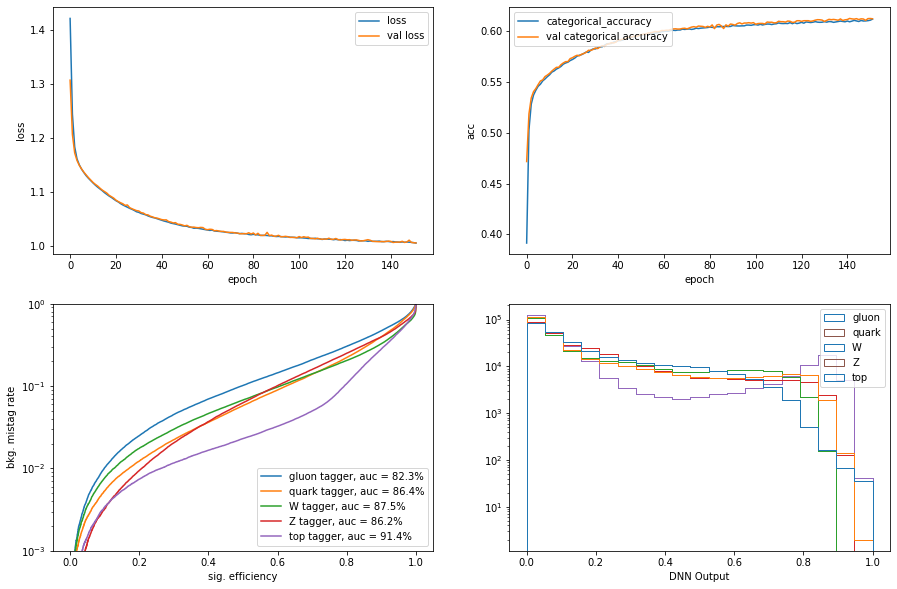

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}

ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)

# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
    
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))

print('Tresholds=',tresholds)

# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')

ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
fig = plt.gcf()
plt.show()    

In [9]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      idx = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][idx])+','+str(fpr[label][idx])+'\n' )
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)


'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''


# Save a sample of events for HLS
njets=3000
print(X_test.shape)
np.save('x_test_8const.npy', X_test[0:njets,:])
np.save('y_test_8const.npy', Y_test[0:njets,:])


(290400, 24)
